#### Network Analysis
#### (Team Project - Samir, Pablo, Amaya, Sarah and Arianne - MS Business Analytics UC Irvine 2018-19

In [2]:
import pandas as pd
import numpy as np

df=pd.DataFrame(pd.read_csv('products.csv'))
df.head()

,id,title,group,salesrank,review_cnt,downloads,rating
0,1,Patterns of Preaching: A Sermon Sampler,Book,396585.0,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,168596.0,12,12,4.5
2,3,World War II Allied Fighter Planes Trading Cards,Book,1270652.0,1,1,5.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289.0,1,1,4.0
4,5,Prayers That Avail Much for Business: Executive,Book,455160.0,0,0,0.0


In [4]:
df_filter=df[(df['group']=='Book')&((df['salesrank']<=150000)&(df['salesrank']>-1))]

df_cop=pd.DataFrame(pd.read_csv('copurchase.csv'))
df_cop_book=df_cop[df_cop.Source.isin(df_filter.id) & df_cop.Target.isin(df_filter.id)]
in_degree=df_cop_book.groupby(['Target'])['Source'].size().reset_index(name='in_degree')
out_degree=df_cop_book.groupby(['Source'])['Target'].size().reset_index(name='out_degree')

x = out_degree.set_index('Source')
y = in_degree.set_index('Target').rename_axis('Source')
y.columns = x.columns

combined=y.add(x, fill_value=0).loc[y.index, :].reset_index()
df_filter.head()
combined.nlargest(5,'out_degree') #Top 5 products with highest in+out degree
#2 products (33 and 4429) with highest degree.

,Source,out_degree
1,33,53.0
360,4429,53.0
23,244,36.0
32,302,22.0
471,5913,22.0


In [6]:
#grouping by source and target products to see if any particular combination has been repeated. 
#We'll use this dataset to build the network graph
df_final_group=df_cop_book.groupby(['Source','Target']).size().reset_index(name='Freq')
df_final_group.head()

,Source,Target,Freq
0,12,261,1
1,74,282,1
2,77,422,1
3,79,82,1
4,117,131,1


The product with the highest degree (in degree + out degree) are 33 and 4429. We’re interested in the sub component off all the products that are directly or indirectly associated with products 33 and 4429. The nodes 33 and 4429 and all its subcomponents were visualized by using a package Networkx. In the graph, larger the size of node, larger the degree for the node and darker color means larger degree. The degree of all nodes varies from 1-53. (A clear picture is attached with the assignment).

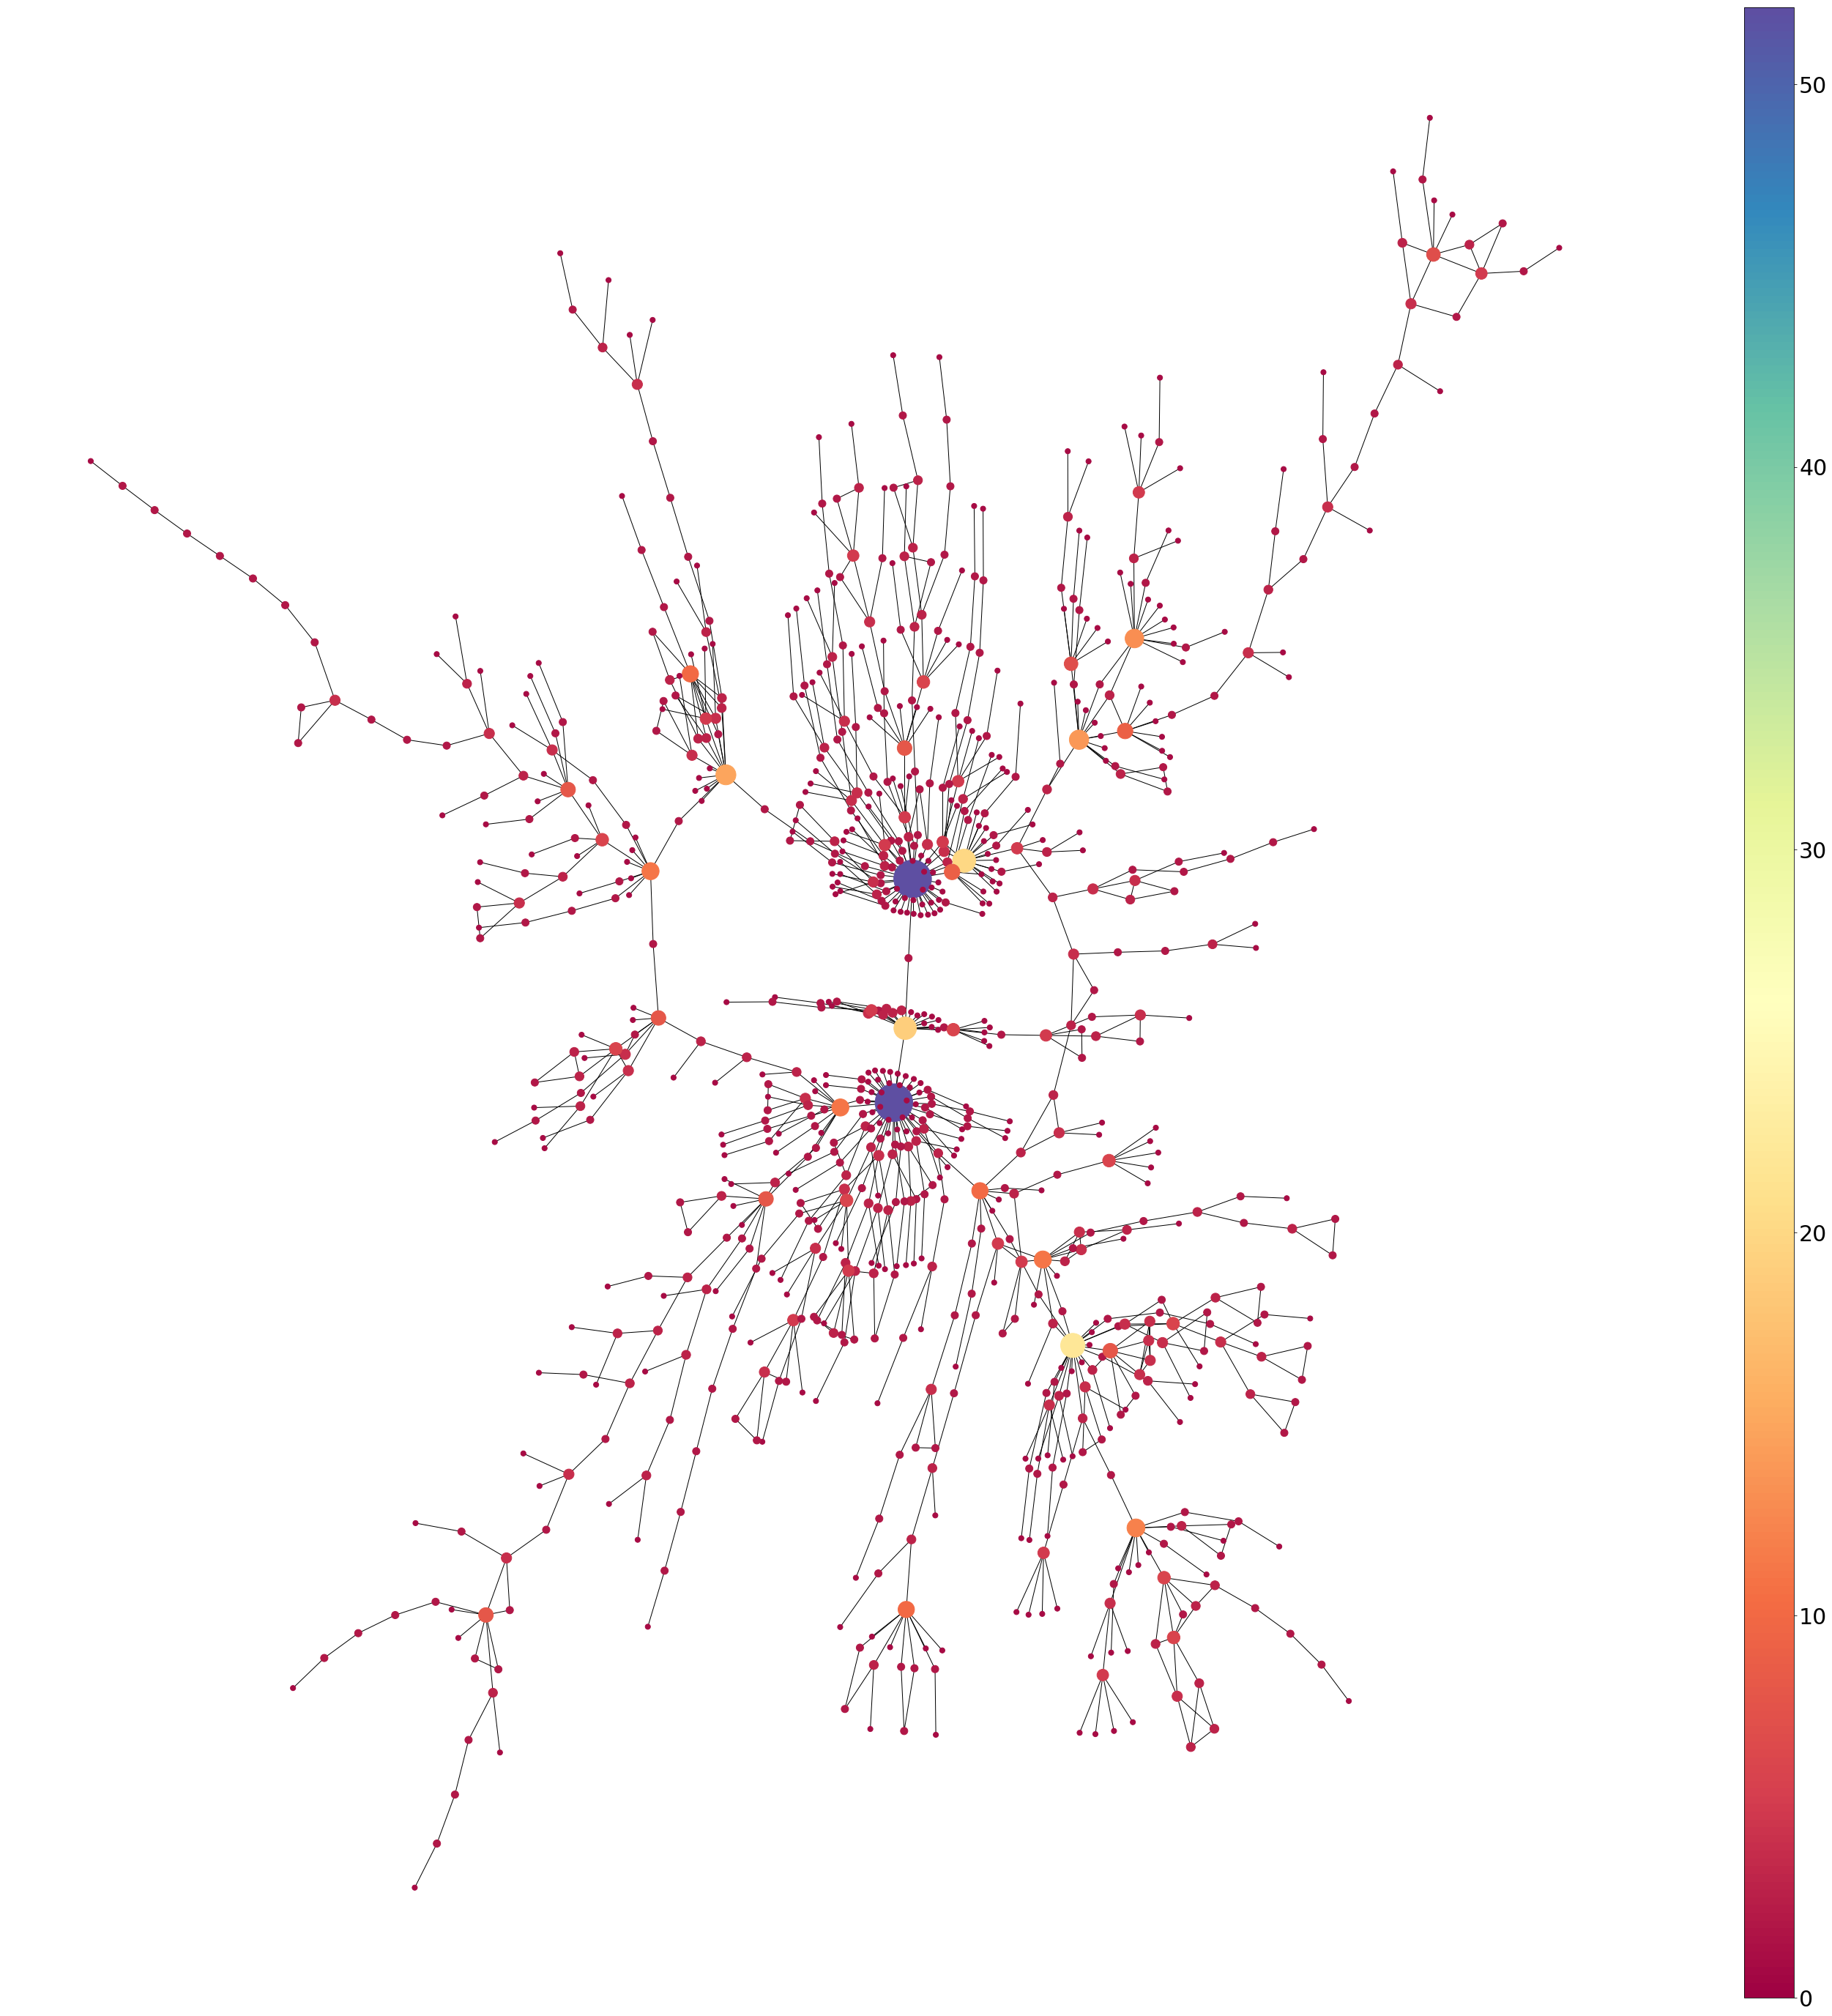

<Figure size 7200x4800 with 0 Axes>

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
import community
from matplotlib.pyplot import subplots
%matplotlib inline

g = nx.from_pandas_edgelist(df_final_group, 'Source', 'Target', ['Freq'])#create_using=nx.Graph()

fig, ax = subplots()
subnet = nx.node_connected_component(g, 4429)
pos=nx.kamada_kawai_layout(g.subgraph(subnet))

cmapC = plt.cm.get_cmap('Spectral')
degrees = dict(g.subgraph(subnet).degree()) #Dict with Node ID, Degree

nodes = dict(g.subgraph(subnet).nodes())
n_color = np.asarray([degrees[n] for n in nodes])
edges = dict(g.subgraph(subnet).edges())
weights = [g.subgraph(subnet)[u][v]['Freq'] for u,v in edges]
colors=range(53)
vmin = min(colors)
vmax = max(colors)

draw=nx.draw_kamada_kawai(g.subgraph(subnet),k=1.2, with_labels = False,
               nodelist=degrees.keys(),node_size=[v*50 for v in degrees.values()]
                     ,cmap=cmapC,width=weights,arrows=True,node_color=n_color,vmin=vmin, vmax=vmax)

plt.xticks([], [])
plt.yticks([], [])
fig = plt.gcf()
fig.set_size_inches(50, 50)
sm = plt.cm.ScalarMappable(cmap=cmapC, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar=plt.colorbar(sm,aspect=40)
cbar.ax.tick_params(labelsize=30)

plt.figure(dpi=1200)
plt.show()

#### Statistics from the graph:
**Degree of the Nodes:**<br/> A histogram look at the degree distribution of the nodes. Degree of a node determines the no of nodes the parent node is connected directly. We can see that the large number of nodes have lower degree (<10) while only few nodes have degree >10.

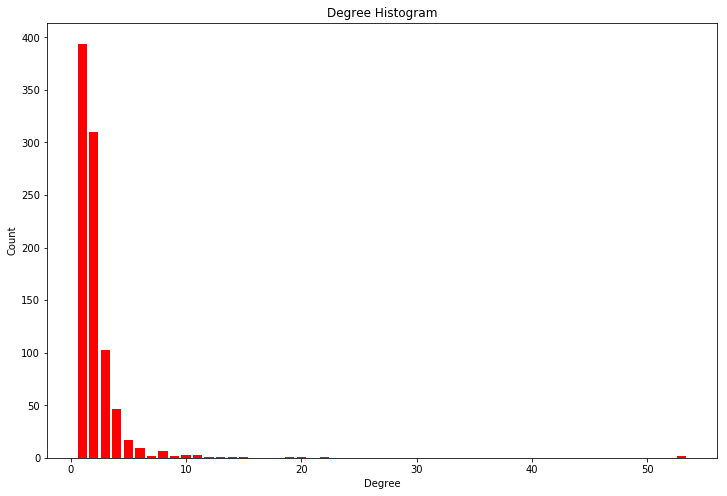

In [4]:
## Degree Histogram for sub-component
import collections
from bokeh.io import show, output_file
from bokeh.plotting import figure
import seaborn as sns
degree_sequence = sorted([d for n, d in g.subgraph(subnet).degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.8, color='r')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [5]:
#Density of sub-component
density_sc=nx.density(g.subgraph(subnet))
density_sc
#Low value of density means less dense the nodes are and little collectiveness between the nodes. 

0.0024622938288301533

#### Degree Centrality of the Nodes:
Degree Centrality of a nodes gives us the fraction of nodes each node it is connected to. Since 2 nodes have highest degree (53), the degree centrality of these nodes is the highest, followed by other nodes with higher degree. We can also see that there are nodes which have similar degree centrality.

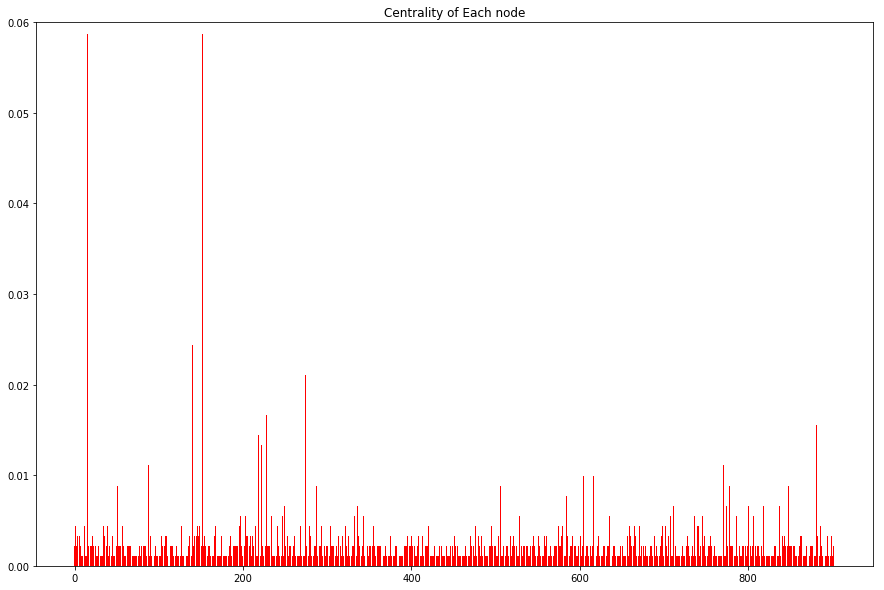

In [6]:
#Centrality of the Nodes.
degree_central=nx.degree_centrality(g.subgraph(subnet))
plt.bar(range(len(degree_central)), list(degree_central.values()),width=0.8, color='r')
# plt.xticks(range(len(degree_central)), list(degree_central.keys()))
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
axes.set_ylim([0,0.06])
plt.title("Centrality of Each node")
plt.show()
#degree centrality=fraction of nodes it is connected to. 2 nodes have highest centrality

#### Closeness Centrality:
Closeness centrality is defined by is the average length of the shortest path between the node and all other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes. For this particular subgraph, the closeness centrality looks similar for most of the nodes.

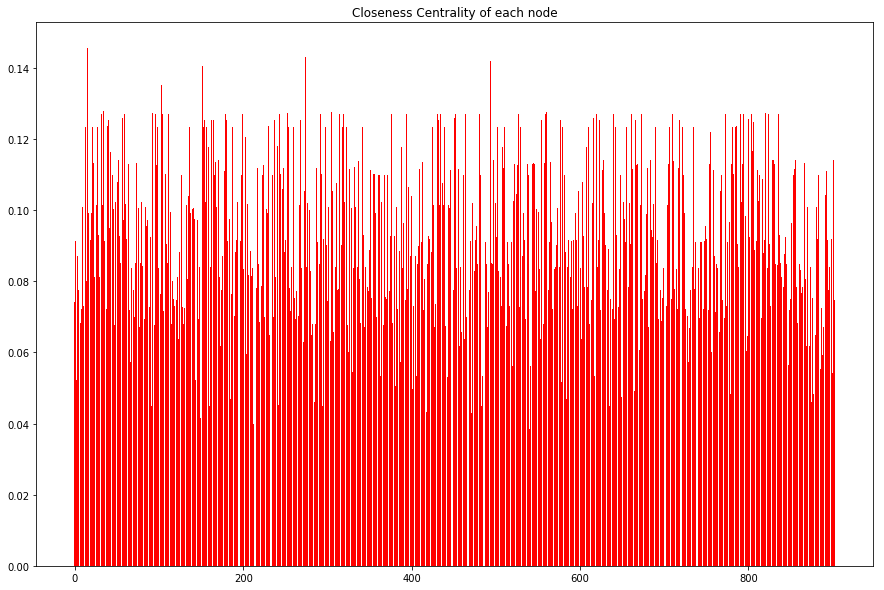

In [7]:
#Closeness Centrality of the Nodes.
close_degree_central=nx.closeness_centrality(g.subgraph(subnet))
plt.bar(range(len(close_degree_central)), list(close_degree_central.values()),width=0.8, color='r')
# plt.xticks(range(len(degree_central)), list(degree_central.keys()))
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
plt.title("Closeness Centrality of each node")
plt.show()
#Closeness Centrality-Closeness centrality of a node u is the reciprocal of the
#average shortest path distance to u over all n-1 reachable nodes.

#### Betweenness Centrality:
Betweenness centrality aims to find the vertex of the given graph. Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass- through v. In the below graph, we can see that few nodes act as the bridge for other nodes to be connected.

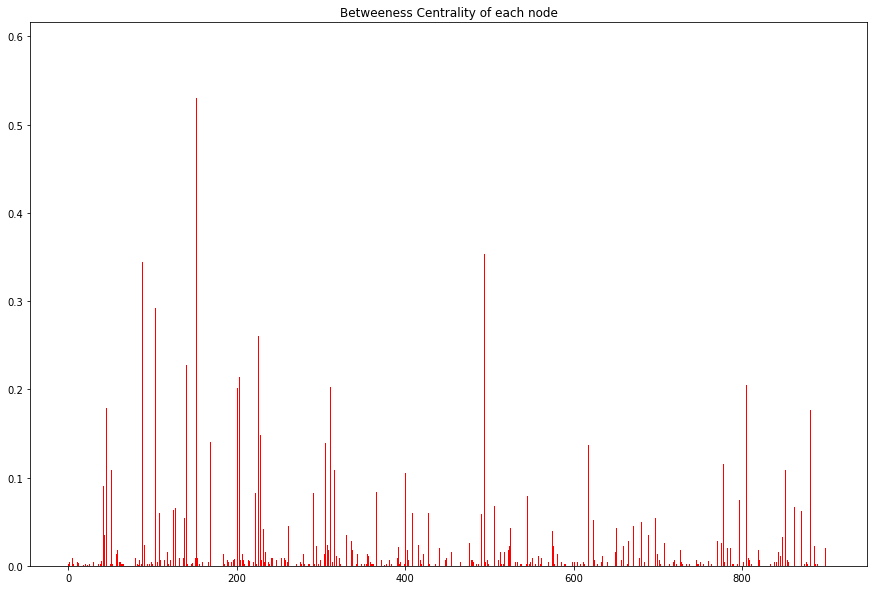

In [8]:
#Between Centrality of the Nodes.
between_degree_central=nx.betweenness_centrality(g.subgraph(subnet))
plt.bar(range(len(between_degree_central)), list(between_degree_central.values()),width=0.8, color='r')
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
plt.title("Betweeness Centrality of each node")
plt.show()
#Between Centrality-Compute the shortest-path betweenness centrality for nodes.
#Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v

#### Eigen Vector Centrality:
Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. It is a relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. In the subgraph, 2 nodes have high eigen vector score. Many other nodes have same score of 0.1, indicating that those nodes have similar in value.

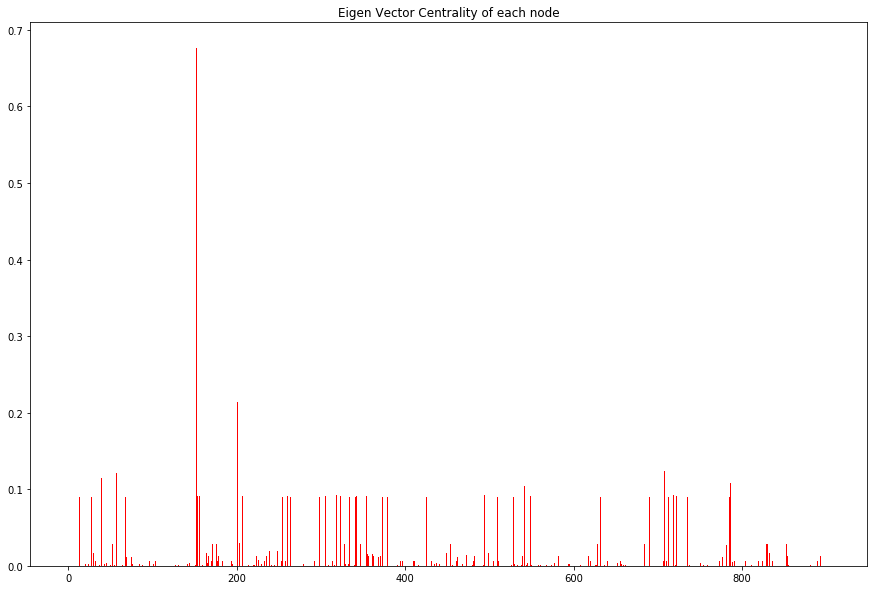

In [9]:
#Eigen Value Centrality of the Nodes.
Eigen_central=nx.eigenvector_centrality_numpy(g.subgraph(subnet))
plt.bar(range(len(Eigen_central)), list(Eigen_central.values()),width=0.8, color='r')
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
plt.title("Eigen Vector Centrality of each node")
plt.show()
#Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. 
#The eigenvector centrality for node i is the i-th element of the vector xdefined by the equation

#### Hub and Authority Score:
Hub score estimates the nodes value based on outgoing links. The authority score indicates the node value based on incoming links. The hub score and Authority score of the subgraph is same for all nodes, indicating that the no of incoming and outgoing nodes are same.

/Users/samirakumar/anaconda/lib/python2.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  hubs = dict(zip(G, map(float, h)))
/Users/samirakumar/anaconda/lib/python2.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:208: ComplexWarning: Casting complex values to real discards the imaginary part
  authorities = dict(zip(G, map(float, a)))


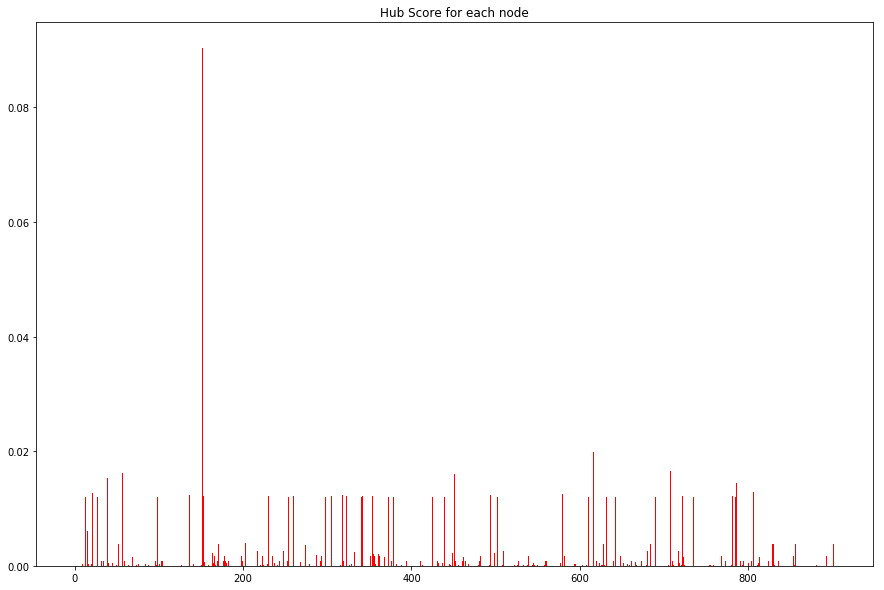

In [10]:
#Hub Score of the Nodes.
hits_score=nx.hits_numpy(g.subgraph(subnet))
plt.bar(range(len(hits_score[0])), list(hits_score[0].values()),width=0.8, color='r')
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
plt.title("Hub Score for each node")
plt.show()
#Hub estimates the node value based on the Outgoing links.

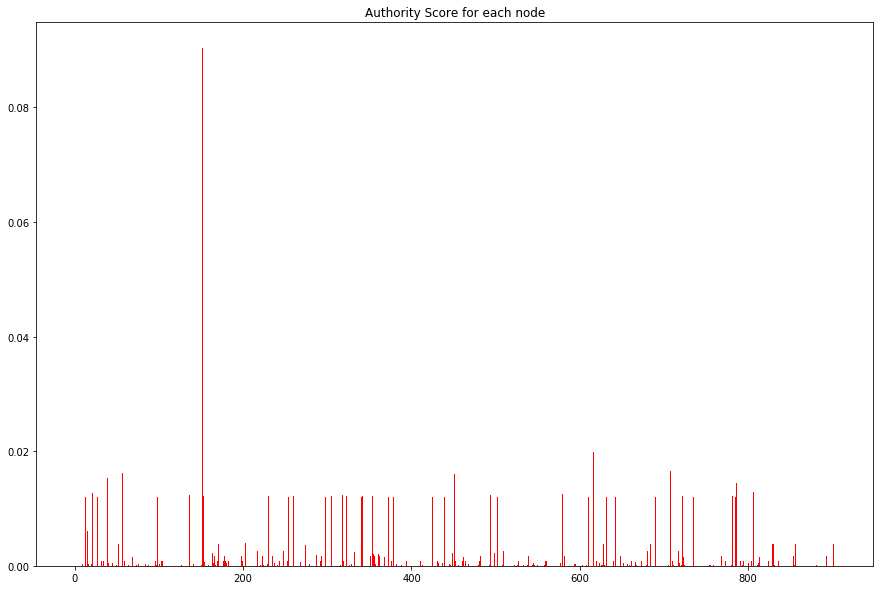

In [11]:
#Authority Score of the Nodes.
hits_score=nx.hits_numpy(g.subgraph(subnet))
plt.bar(range(len(hits_score[1])), list(hits_score[1].values()),width=0.8, color='r')
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
plt.title("Authority Score for each node")
plt.show()
#Authorities estimates the node value based on the incoming links.

#### Average Degree Neighbor:
Average degree of neighbor indicates the average degree of the neighbor for a given node. This gives us a good indication of the degree of the neighboring nodes for a given node. In the below graph, we can see that nodes only connected to 33 or 4429 directly have average degree 53 but the dispersion of the average degree is high.

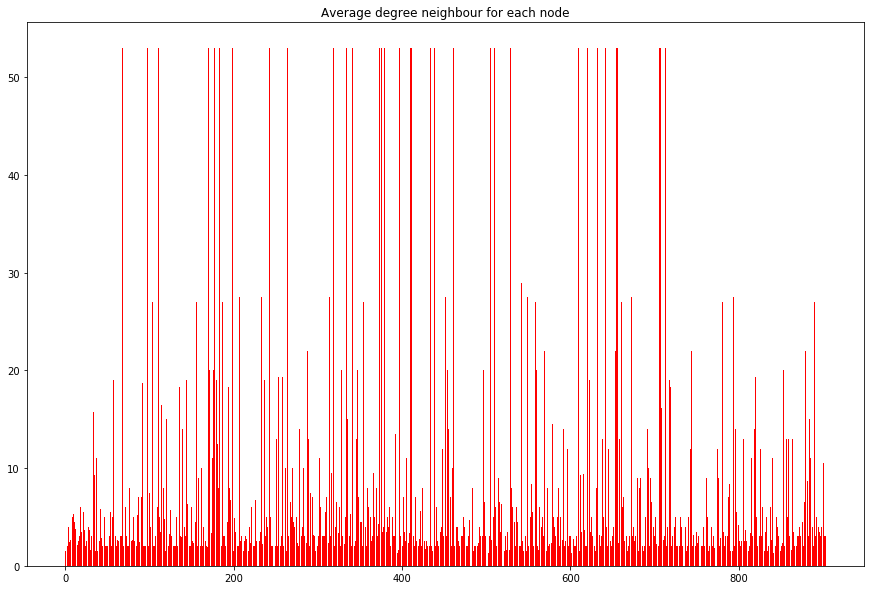

In [12]:
#Average Degree Neighbour
degree_assort=nx.average_neighbor_degree(g.subgraph(subnet))
plt.bar(range(len(degree_assort)), list(degree_assort.values()),width=0.8, color='r')
fig = plt.gcf()
axes=plt.gca()
fig.set_size_inches(15,10)
plt.title("Average degree neighbour for each node")
plt.show()
#Returns the average degree of the neighborhood of each node.

#### Diameter of Network:
The shortest distance/path length between the two most distant connected nodes in the network (the
longest of all the calculated path lengths). In the subgraph, the diameter is 41.


In [13]:
#Diameter of the network graph
nx.diameter(g.subgraph(subnet))
#The shortest distance/path length between the two most distant connected nodes in the 
#network ( = the longest of all the calculated path lengths).

41

#### Average Rating, Salesrank and Review Count for the nodes:
We calculated overall average for Rating, Salesrank and Review Count for the subgraph.


In [14]:
filter_4429=df_final_group[(df_final_group['Source']==4429)|(df_final_group['Target']==4429)]
merged=pd.merge(filter_4429,df_filter,how='left', left_on=['Source'],right_on=['id'])
merged.loc[merged.id==4429,'title']='The Narcissistic Family : Diagnosis and Treatment'
merged.loc[merged.id==4429,'salesrank']=9727
merged.loc[merged.id==4429,'review_cnt']=19
merged.loc[merged.id==4429,'downloads']=19
merged.loc[merged.id==4429,'rating']=5.0
merged.loc[merged.id==4429,'id']=2501
merged[['rating','salesrank','review_cnt']].mean()

rating            3.632075
salesrank     75080.471698
review_cnt       22.037736
dtype: float64

## Digging Deeper:
Since the neighbor (source/target) for each product node can have an influence on the product purchase, we're finding the salesrank, rating and review count for each product.<br/> Example: If product 33 is associated with 55 and 66, then both 55 and 66 influence the purchase of 33. So we find the total salesrank, total reviews and rating for each product associated with each product. So for products 33 and 4429, we know they've highest degree (53). So for them we'd find salesrank, rating and review for the 53 products associated with them. This is done for all products in source and target.<br/>
<br/>
    The programming logic is simple, for source, we consider target and get salesrank of all the source products. We the consider source and get salesrank for all target products. We then groupby source and sum up all target salesrank. Then groupby target and sum up source targets. So for each product, we ge the total salesrank of all the products associated with it as either source or target.<br/> <br/>**Consider below example:**<br/><br/>**source-target-salesrank_source-salesrank_target**<br/>
    33-55-5-10<br/>33-66-5-15<br/>44-33-20-5<br/><br/>**id-Source_sum-Target_Sum**<br/>
    33-25-20<br/>44-5-0<br/>55-5-0<br/>66-5-0<br/><br/>
    33 is source for 2 products. So their salesrank sum is 10+15=25 and 33 is target for one node. So its total salesrank is 20. So total salesrank for all products associated with 33 is 45 (10+15+20).
<br/> To find salesrank sum of neighbors of product 33, we first get salesrank of products 55 and 66 and store them as salesrank_target since they are in target column. Then we get salesrank of 44 and store them as salesrank_source. So now when we groupby source and sum salesrank_target, we store it as Source_sum. Then we groupby target and store the salesrank_source sum as Target_sum. We then add both Source_sum and Target_sum to get total salesrank for associated products for each product. Here's the catch. For some products, it can be present in only source/target. So if they're missing in either source/target, we consider them as 0 and make the combined dataframe.<br/><br/>Same process is followed for rating and review count.

In [29]:
#Get the edges for each nodes from the network graph and store them in edges dataframe. From the initial table,
# we get the salesrank, rating and review detail for all the products. 
h=g.subgraph(subnet)
edges=pd.DataFrame(list(h.edges()))
edges=edges.rename(columns={'0':'Source','1':'Target'})

#total salesrank
df_cop_sales=pd.merge(edges,df_filter[['id','salesrank']],left_on=1,right_on='id',how='left')
df_cop_sales=df_cop_sales.rename(columns={'salesrank':'salesrank_target'})

df_cop_sale=pd.merge(edges,df_filter[['id','salesrank']],left_on=0,right_on='id',how='left')
df_cop_sale=df_cop_sale.rename(columns={'salesrank':'salesrank_source'})

df_cop_sale['salesrank_target']=df_cop_sales['salesrank_target']
df_source_sum=df_cop_sale.groupby(0)['salesrank_target'].sum().reset_index(name='Source_sum')
df_target_sum=df_cop_sale.groupby(1)['salesrank_source'].sum().reset_index(name='Target_sum')

x = df_source_sum.set_index(0)
y = df_target_sum.set_index(1).rename_axis(0)
y.columns = x.columns

combined=y.add(x, fill_value=0)
combined=pd.DataFrame(combined)
combined=combined.rename(columns={'0':'id','Source_sum':'Total_salesrank'})
combined.head()

,Total_salesrank
0,
33,4354123.0
77,125232.0
78,804969.0
130,159895.0
148,60293.0


In [25]:
#Total rating
df_cop_rating=pd.merge(edges,df_filter[['id','rating']],left_on=1,right_on='id',how='left')
df_cop_rating=df_cop_rating.rename(columns={'rating':'rating_target'})

df_cop_rate=pd.merge(edges,df_filter[['id','rating']],left_on=0,right_on='id',how='left')
df_cop_rate=df_cop_rate.rename(columns={'rating':'rating_source'})
df_cop_rate['rating_target']=df_cop_rating['rating_target']

df_source_rate_sum=df_cop_rate.groupby(0)['rating_target'].sum().reset_index(name='Source_sum')
df_target_rate_sum=df_cop_rate.groupby(1)['rating_source'].sum().reset_index(name='Target_sum')

x = df_source_rate_sum.set_index(0)
y = df_target_rate_sum.set_index(1).rename_axis(0)
y.columns = x.columns

combined_rating=y.add(x, fill_value=0)
combined_rating=pd.DataFrame(combined_rating)
combined_rating=combined_rating.rename(columns={'0':'id','Source_sum':'Total_rating'})
combined_rating.head()

,Total_rating
0,
33,217.5
77,14.0
78,49.5
130,9.0
148,4.5


In [26]:
#Total review count
df_cop_reviews=pd.merge(edges,df_filter[['id','review_cnt']],left_on=1,right_on='id',how='left')
df_cop_reviews=df_cop_reviews.rename(columns={'review_cnt':'review_cnt_target'})

df_cop_review=pd.merge(edges,df_filter[['id','review_cnt']],left_on=0,right_on='id',how='left')
df_cop_review=df_cop_review.rename(columns={'review_cnt':'review_cnt_source'})
df_cop_review['review_cnt_target']=df_cop_reviews['review_cnt_target']

df_source_review_sum=df_cop_review.groupby(0)['review_cnt_target'].sum().reset_index(name='Source_sum')
df_source_reviews_sum=df_cop_review.groupby(1)['review_cnt_source'].sum().reset_index(name='Target_sum')

x = df_source_review_sum.set_index(0)
y = df_source_reviews_sum.set_index(1).rename_axis(0)
y.columns = x.columns

combined_reviews=y.add(x, fill_value=0)
combined_reviews=pd.DataFrame(combined_reviews)
combined_reviews=combined_reviews.rename(columns={'0':'id','Source_sum':'Total_review_cnt'})
combined_reviews.head()

,Total_review_cnt
0,
33,1117.0
77,12.0
78,1736.0
130,9.0
148,14.0


#### Average salesrank, rating and review count: 
By finding out the degree for each node, we can find the average salesrank, rating and review count for each product.

In [22]:
degrees=pd.DataFrame(list(h.degree()))
degrees=degrees.sort_values(0)
degrees.head()

,0,1
14,33,53
211,77,3
140,78,11
57,130,2
776,148,2


In [23]:
df_merge_sales=pd.merge(combined,degrees,left_on=0,right_on=0,how='left')
df_merge_sales['Average_Salesrank']=df_merge_sales['Total_salesrank']/df_merge_sales[1]
df_merge_sales=df_merge_sales.rename(columns={'key_0':'id',1:'Degree'})
df_merge_sales.head()

,id,Total_salesrank,Degree,Average_Salesrank
0,33,4354123.0,53,82153.264151
1,77,125232.0,3,41744.000000
2,78,804969.0,11,73179.000000
3,130,159895.0,2,79947.500000
4,148,60293.0,2,30146.500000


In [27]:
df_merge_rating=pd.merge(combined_rating,degrees,left_on=0,right_on=0,how='left')
df_merge_rating['Average_Rating']=df_merge_rating['Total_rating']/df_merge_rating[1]
df_merge_rating=df_merge_rating.rename(columns={'key_0':'id',1:'Degree'})
df_merge_rating.head()

,id,Total_rating,Degree,Average_Rating
0,33,217.5,53,4.103774
1,77,14.0,3,4.666667
2,78,49.5,11,4.500000
3,130,9.0,2,4.500000
4,148,4.5,2,2.250000


In [28]:
df_merge_reviews=pd.merge(combined_reviews,degrees,left_on=0,right_on=0,how='left')
df_merge_reviews['Average_Reviews']=df_merge_reviews['Total_review_cnt']/df_merge_reviews[1]
df_merge_reviews=df_merge_reviews.rename(columns={'key_0':'id',1:'Degree'})
df_merge_reviews.head()

,id,Total_review_cnt,Degree,Average_Reviews
0,33,1117.0,53,21.075472
1,77,12.0,3,4.000000
2,78,1736.0,11,157.818182
3,130,9.0,2,4.500000
4,148,14.0,2,7.000000


#### Network Graph parameters:
From the network graph, we're finding each parameters for each node and adding them to the dataframe.

In [16]:
centrality_df=pd.DataFrame(degree_central.items(),columns=['id','centrality'])
degree_df=pd.DataFrame(degrees.items(),columns=['id','degree'])
closeness_central_df=pd.DataFrame(close_degree_central.items(),columns=['id','closeness_centrality'])
between_degree_df=pd.DataFrame(between_degree_central.items(),columns=['id','between_centrality'])
Eigen_central_df=pd.DataFrame(Eigen_central.items(),columns=['id','eigen_centrality'])
hubs_score_df=pd.DataFrame(hits_score[0].items(),columns=['id','hub_score'])
authority_score_df=pd.DataFrame(hits_score[1].items(),columns=['id','authority_score'])
avg_degree_neighbour_df=pd.DataFrame(degree_assort.items(),columns=['id','avg_degree_neighbour'])
centrality_df.head()
#filter purchase dataset

,id,centrality
0,24578,0.002215
1,4099,0.004430
2,141316,0.002215
3,2057,0.003322
4,122893,0.002215


In [78]:
df_filter_books=df_filter[(df_filter.id.isin(centrality_df.id)) & (df_filter.id.isin(degree_df.id))
                          &(df_filter.id.isin(between_degree_df.id))&(df_filter.id.isin(Eigen_central_df.id))
                         &(df_filter.id.isin(hubs_score_df.id))&(df_filter.id.isin(authority_score_df.id))
                         &(df_filter.id.isin(avg_degree_neighbour_df.id))]
df_filter_books.head()
df_filter_books=pd.merge(df_filter_books,centrality_df,left_on='id',right_on='id',how='left')
df_filter_books=pd.merge(df_filter_books,degree_df,left_on='id',right_on='id',how='left')
df_filter_books=pd.merge(df_filter_books,closeness_central_df,left_on='id',right_on='id',how='left')
df_filter_books=pd.merge(df_filter_books,between_degree_df,left_on='id',right_on='id',how='left')
df_filter_books=pd.merge(df_filter_books,Eigen_central_df,left_on='id',right_on='id',how='left')
df_filter_books=pd.merge(df_filter_books,hubs_score_df,left_on='id',right_on='id',how='left')
df_filter_books=pd.merge(df_filter_books,authority_score_df,left_on='id',right_on='id',how='left')
df_filter_books=pd.merge(df_filter_books,avg_degree_neighbour_df,left_on='id',right_on='id',how='left')

df_filter_books=pd.merge(df_filter_books,df_merge_sales[['key_0','Average_Salesrank']],left_on='id',right_on='key_0',how='left')
df_filter_books=pd.merge(df_filter_books,df_merge_rating[['key_0','Average_Rating']],left_on='id',right_on='key_0',how='left')
df_filter_books=pd.merge(df_filter_books,df_merge_reviews[['key_0','Average_Reviews']],left_on='id',right_on='key_0',how='left')
df_filter_books=df_filter_books.drop('key_0_x',1)
df_filter_books=df_filter_books.drop('key_0_y',1)
df_filter_books=df_filter_books.drop('key_0',1)
df_filter_books.head()

,id,title,group,salesrank,review_cnt,downloads,rating,centrality,degree,closeness_centrality,between_centrality,eigen_centrality,hub_score,authority_score,avg_degree_neighbour,Average_Salesrank,Average_Rating,Average_Reviews
0,33,"Double Jeopardy (T*Witches, 6)",Book,97166.0,4,4,5.0,0.058693,53,0.145598,0.586724,4.542173e-02,6.067368e-03,6.067368e-03,2.132075,82153.264151,4.103774,21.075472
1,77,Water Touching Stone,Book,27012.0,11,11,4.5,0.003322,3,0.081682,0.013235,7.515199e-08,1.003869e-08,1.003869e-08,2.000000,41744.000000,4.666667,4.000000
2,78,The Ebony Cookbook: A Date With a Dish,Book,140480.0,3,3,4.5,0.012182,11,0.107615,0.053657,3.038877e-05,4.059287e-06,4.059287e-06,2.909091,73179.000000,4.500000,157.818182
3,130,"The O'Reilly Factor: The Good, the Bad, and th...",Book,29460.0,375,375,3.5,0.002215,2,0.097338,0.017581,4.084168e-06,5.455571e-07,5.455571e-07,6.500000,79947.500000,4.500000,4.500000
4,148,Firebird,Book,77008.0,42,42,4.0,0.002215,2,0.091194,0.004425,7.562043e-07,1.010127e-07,1.010127e-07,12.000000,30146.500000,2.250000,7.000000


In [79]:
df_log=df_filter_books

df_log['review_cnt']=np.log(df_log['review_cnt']+1)
df_log['downloads']=np.log(df_log['downloads']+1)
df_log['rating']=np.log(df_log['rating']+1)
df_log['centrality']=np.log(df_log['centrality']+1)
df_log['degree']=np.log(df_log['degree']+1)
df_log['closeness_centrality']=np.log(df_log['closeness_centrality']+1)
df_log['between_centrality']=np.log(df_log['between_centrality']+1)
df_log['eigen_centrality']=np.log(df_log['eigen_centrality']+1)
df_log['hub_score']=np.log(df_log['hub_score']+1)
df_log['authority_score']=np.log(df_log['authority_score']+1)
df_log['avg_degree_neighbour']=np.log(df_log['avg_degree_neighbour']+1)
df_log['Average_Salesrank']=np.log(df_log['Average_Salesrank']+1)
df_log['Average_Rating']=np.log(df_log['Average_Rating']+1)
df_log['Average_Reviews']=np.log(df_log['Average_Reviews']+1)
# df_dummy['nghb_mn_rating_y']=np.log(df_dummy['nghb_mn_rating_y']+1)
# df_dummy['nghb_mn_review']=np.log(df_dummy['nghb_mn_review']+1)


df_log.tail()

,id,title,group,salesrank,review_cnt,downloads,rating,centrality,degree,closeness_centrality,between_centrality,eigen_centrality,hub_score,authority_score,avg_degree_neighbour,Average_Salesrank,Average_Rating,Average_Reviews
899,261523,Ghosts of Tsavo: Tracking the Mythic Lions of ...,Book,91750.0,2.484907,2.484907,1.609438,0.002212,1.098612,0.094531,0.004415,0.001640,0.000219,0.000219,1.098612,10.751596,1.658228,1.504077
900,261524,Object-Oriented Programming in Common Lisp: A ...,Book,79520.0,1.386294,1.386294,1.704748,0.002212,1.098612,0.086387,0.002212,0.000221,0.000029,0.000029,0.916291,10.933089,1.609438,5.049856
901,261898,How To Be A Para Pro : A Comprehensive Trainin...,Book,122234.0,1.945910,1.945910,1.704748,0.002212,1.098612,0.106947,0.002212,0.000820,0.000110,0.000110,0.916291,11.861781,1.658228,2.079442
902,261899,The Listening Walk,Book,146686.0,1.386294,1.386294,1.704748,0.002212,1.098612,0.119722,0.004415,0.006086,0.000815,0.000815,3.349904,11.605514,1.749200,1.791759
903,261966,The Best Little Beading Book (Beadwork Books),Book,136801.0,2.484907,2.484907,1.609438,0.001107,0.693147,0.096616,0.000000,0.000108,0.000014,0.000014,1.098612,11.713701,1.704748,1.945910


#### Regression model to predict the salesrank of the product given other parameters.

In [251]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.genmod.families import Poisson,Binomial

X = df_log[['review_cnt','downloads','rating','centrality','between_centrality','closeness_centrality','eigen_centrality','authority_score'
              ,'avg_degree_neighbour','Average_Salesrank','Average_Rating','Average_Reviews']]
X = sm.add_constant(X)

y = df_log.salesrank

poisson_model = smf.poisson('salesrank ~ review_cnt+downloads+ rating+centrality+between_centrality+closeness_centrality+eigen_centrality+authority_score + avg_degree_neighbour+ Average_Salesrank+Average_Rating+Average_Reviews', df_log)

res=poisson_model.fit(method='bfgs')

res.summary()

         Current function value: 14142.163464
         Iterations: 34
         Function evaluations: 43
         Gradient evaluations: 42


/Users/samirakumar/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:              salesrank   No. Observations:                  904
Model:                        Poisson   Df Residuals:                      891
Method:                           MLE   Df Model:                           12
Date:                Wed, 07 Nov 2018   Pseudo R-squ.:                 0.09718
Time:                        19:08:52   Log-Likelihood:            -1.2785e+07
converged:                      False   LL-Null:                   -1.4161e+07
                                        LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.9255      0.002   5185.527      0.000      10.921      10.930
review_cnt              -0.3315      0.003   -129.287      0.000      -0.337      -0.326
downloads                0.1655      0.003     64.490      0.000       0.160       0.171
rating                   0.1016      0.000    390.267      0.000       0.101       0.102
centrality              -8.1959      0.067   -122.140      0.000      -8.327      -8.064
between_centrality       0.4435      0.005     89.255      0.000       0.434       0.453
closeness_centrality    -0.6735      0.008    -85.707      0.000      -0.689      -0.658
eigen_centrality       -16.5839      0.052   -316.531      0.000     -16.687     -16.481
authority_score        109.3204      0.342    319.884      0.000     108.651     109.990
avg_degree_neighbour     0.0753      0.000    380.543      0.000       0.075       0.076
Average_Salesrank        0.0430      0.000    241.128      0.000       0.043       0.043
Average_Rating          -0.0593      0.000   -161.523      0.000      -0.060      -0.059
Average_Reviews          0.0038      0.000     32.092      0.000       0.004       0.004
========================================================================================
"""

In [252]:
y_pred = res.predict(X)
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print mse,mae

1799617311.4698195 36367.79088431795


In [253]:
print('Parameters: ', res.params)
print('T-values: ', res.tvalues)
from sklearn.metrics import accuracy_score,r2_score

errors = abs(y_pred - y)

print('Variance score: %.2f' % r2_score(y, y_pred))
print('Mean Absolute Error:', round(np.mean(errors), 2), 'salesrank.')

mape = 100 * (errors / y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

('Parameters: ', Intercept                10.925529
review_cnt               -0.331510
downloads                 0.165527
rating                    0.101626
centrality               -8.195922
between_centrality        0.443548
closeness_centrality     -0.673488
eigen_centrality        -16.583895
authority_score         109.320403
avg_degree_neighbour      0.075330
Average_Salesrank         0.043040
Average_Rating           -0.059289
Average_Reviews           0.003754
dtype: float64)
('T-values: ', Intercept               5185.527173
review_cnt              -129.287415
downloads                 64.489734
rating                   390.267055
centrality              -122.140239
between_centrality        89.255351
closeness_centrality     -85.706590
eigen_centrality        -316.531474
authority_score          319.883670
avg_degree_neighbour     380.543409
Average_Salesrank        241.127911
Average_Rating          -161.522590
Average_Reviews           32.092003
dtype: float64)
Variance scor

In [241]:
y_pred[0:5],y[0:5]

(0    54117.163709
 1    63320.558265
 2    75090.616702
 3    38723.365700
 4    57808.631127
 dtype: float64, 0     97166.0
 1     27012.0
 2    140480.0
 3     29460.0
 4     77008.0
 Name: salesrank, dtype: float64)

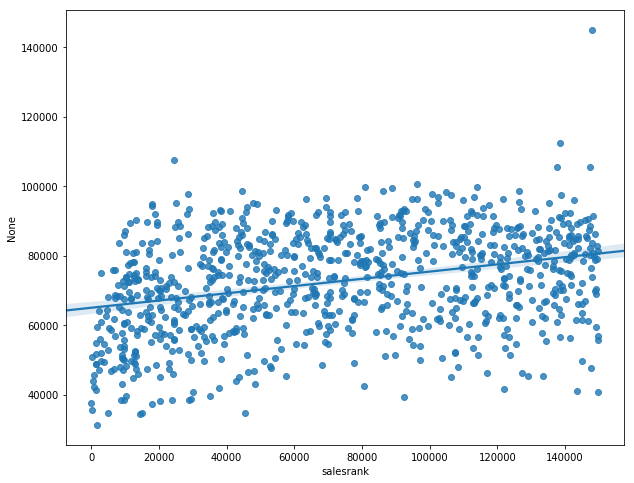

In [254]:
fig=plt.gcf()
fig.set_size_inches(10,8)
# plt.scatter(y,y_pred)
# plt.title('Train dataset Real vs. Predicted Values')
# plt.show()
import seaborn as sns
sns.regplot(y,y_pred)
plt.show()

Text(0,0.5,'Residuals')

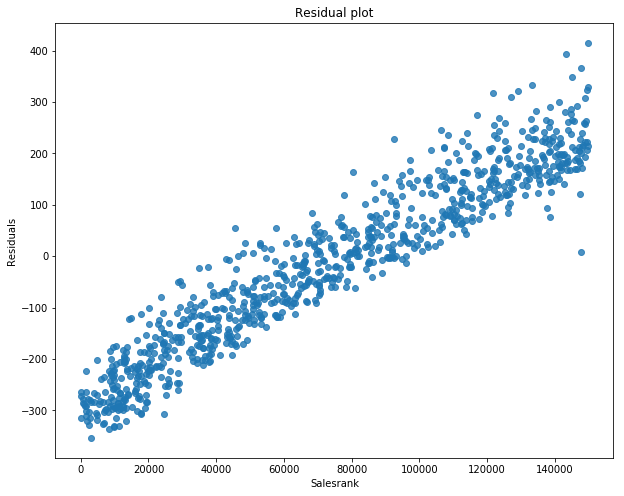

In [243]:
fig=plt.gcf()
fig.set_size_inches(10,8)


X = sm.add_constant(X)
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
sns.regplot(df_log['salesrank'], model.resid_deviance, fit_reg=False)
plt.title('Residual plot')
plt.xlabel('Salesrank')
plt.ylabel('Residuals')

### Interpretation from model:
The value of intercept has a meaning here since a product can be purchased alone and it can have a sales rank even if it doesn’t have any co-product.
P-values of all the variables are less than 0.05, indicating that they’re significant in the model. As seen in the R model, the variables used are significant in predicting the salesrank.
The model was initially built with large no of variables and the insignificant variables were later dropped from the model.
The authority score has the highest coefficient, indicating that for every value increase in authority score, the salesrank tends to increase. The authority score is no of incoming nodes. So products which are purchased as target product tends to have higher sales rank than products that are purchased as source product.
The final model’s mean absolute deviation value is about 210.55 and mean of residuals is 28885 indicating a good fit of the parameters.